# Hierarchical Dirichlet Process Gamma Mixture Model for Terahertz Band Wireless Communication Channel Modelling 

In [363]:
import arviz as az
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
# import seaborn as sns

import pymc3.distributions.transforms as tr

from matplotlib import pyplot as plt
from theano import tensor as tt
from scipy.io import savemat

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v3.11.5


In [364]:
%config InlineBackend.figure_format = 'retina'
SEED = 8927
rng = np.random.default_rng(SEED)
az.style.use("arviz-darkgrid")

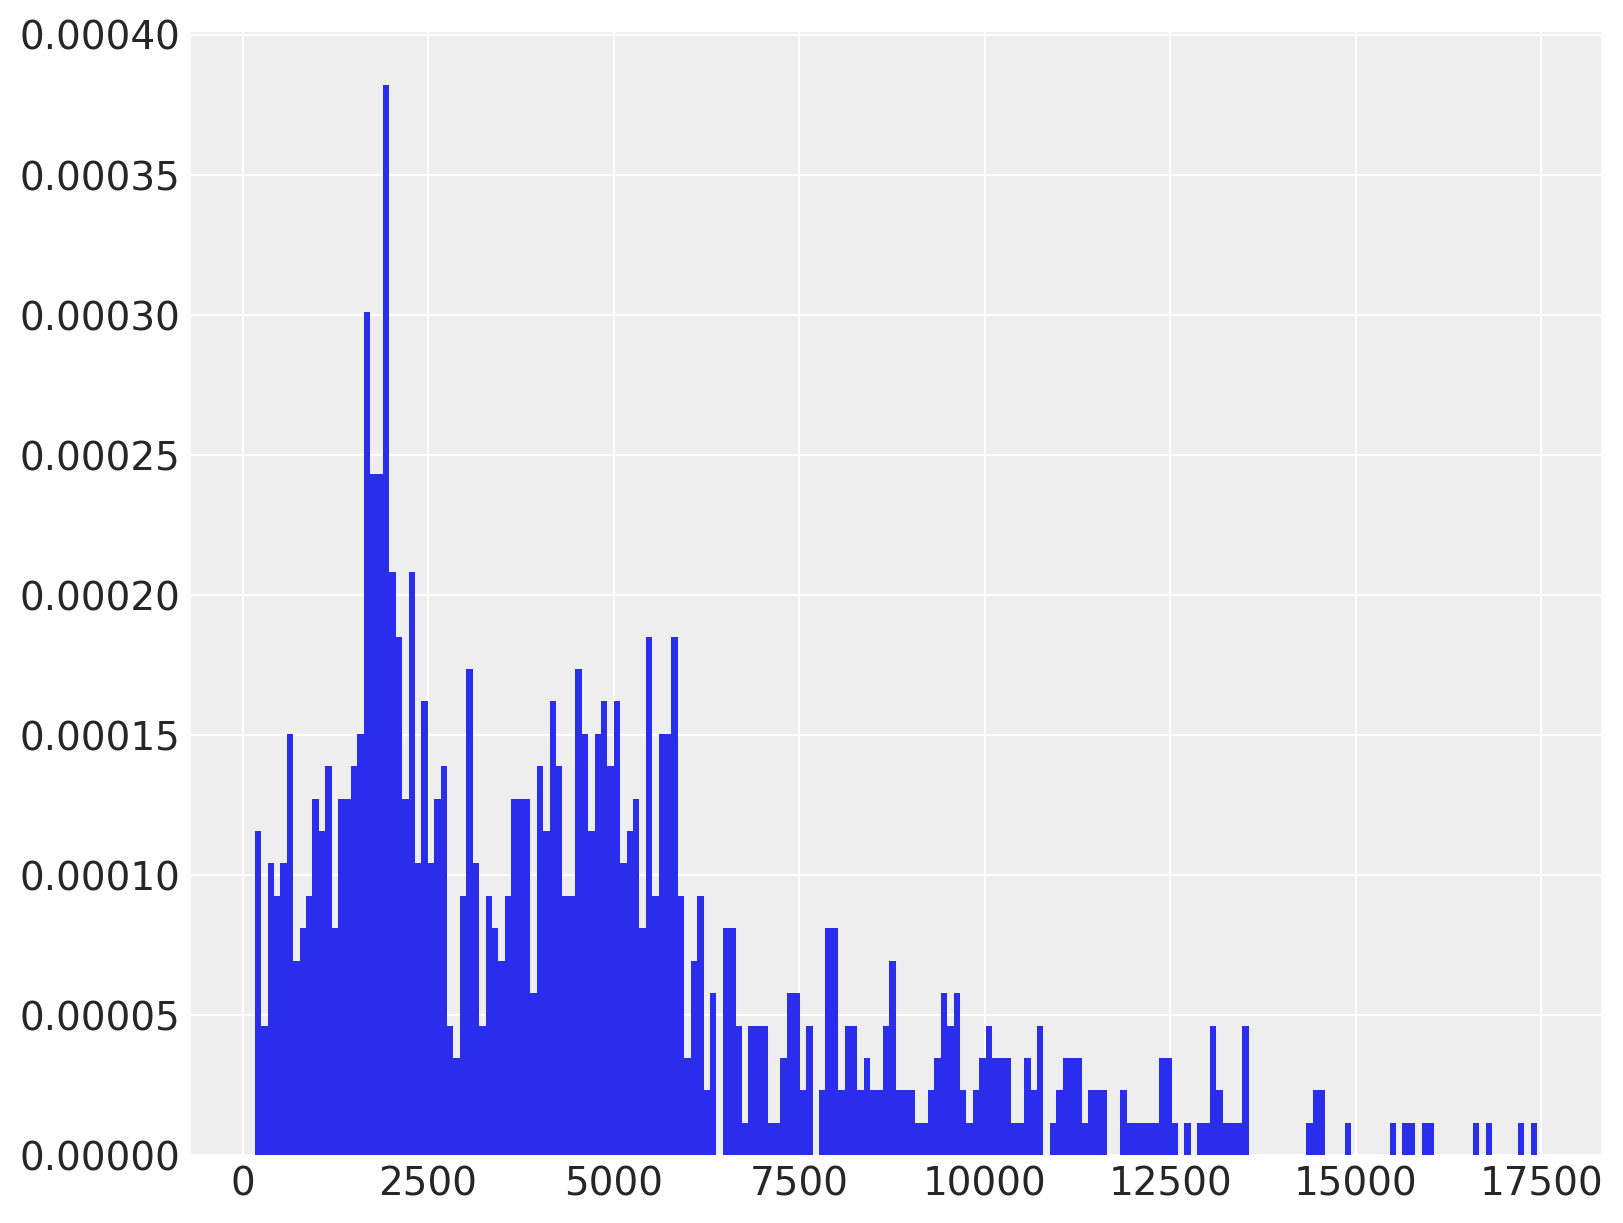

In [365]:
N = 1000

W = np.array([0.1, 0.1, 0.1, 0.1, 0.1,0.1, 0.1, 0.1, 0.1, 0.1])

ALPHA_V = np.array([4, 30, 60, 50, 30, 20, 10, 30, 40, 25])
BETA_V = np.array([200,400, 150, 110, 150, 300, 200, 60, 100,100])

component = rng.choice(ALPHA_V.size, size=N, p=W)
x = rng.gamma(ALPHA_V[component], BETA_V[component], size=N)

fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(x, bins=200, density=True, lw=0);

In [366]:
# # THz_received_power = pd.read_csv("THz_measurement_data.csv")
# THz_received_power = pd.read_csv("all_cm.csv")
# THz_received_power.head()
# # len(THz_received_power.twenty_cm)

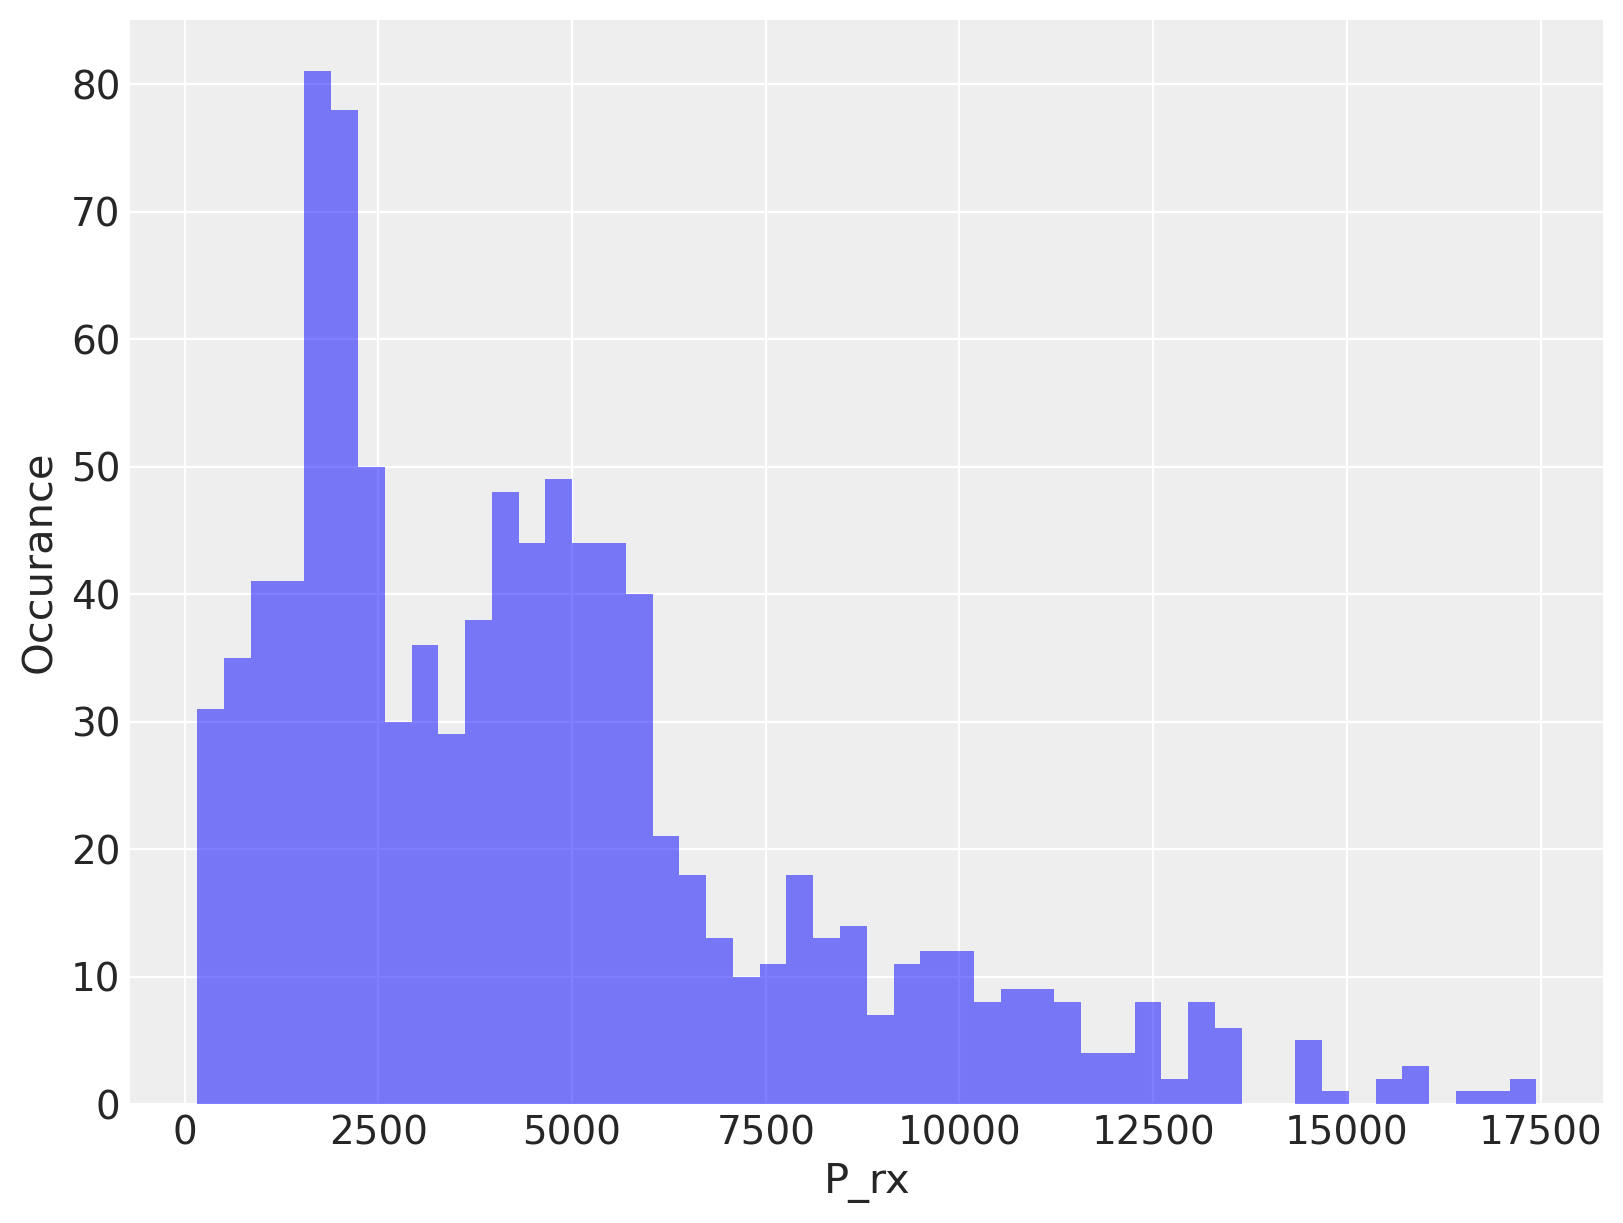

In [367]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 50
ax.hist(x, bins=n_bins, color="blue", lw=0, alpha=0.5)

ax.set_xlabel("P_rx")
ax.set_ylabel("Occurance");

In [368]:
# Truncation number
K=30

In [369]:
# Function for Eq (16)
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

In [370]:
# Hyper-priors with vague values
var_phi = 1
var_rho = 1
epsilon_= 1
mu_     = 1

var_theta = 1
var_pi    = 1
zeta_     = 0.001

In [386]:
# Dirichlet Process Gamma Mixture Model 
with pm.Model() as model: 

    # Eq (28a)
    alpha = pm.Gamma("alpha", 1, 0.55)
    # alpha = 1.5
    # Eq (28b)
    beta = pm.Beta("beta", 1, alpha, shape=K)
    # Eq (28c)
    w = pm.Deterministic("w", stick_breaking(beta))

    # Eq (28d)
    lambda_  = pm.InverseGamma("lambda_", alpha = var_theta, beta= var_pi, shape = K )
    # Eq (28e)
    kappa_   = pm.Exponential("kappa_",    lam   = zeta_, shape = K)

    # Eq (28f)
    upsilon_ = pm.Gamma("upsilon_", alpha = var_phi , beta = var_rho , shape = K )
    # Eq (28g)
    nu_      = pm.InverseGamma("nu_", alpha = epsilon_ , beta = mu_ , shape = K )
    
    # Eq (28h)
    alpha_   = pm.InverseGamma("alpha_", alpha = lambda_, beta = kappa_, shape = K )
    beta_    = pm.Gamma("beta_", alpha = nu_ , beta = upsilon_ , shape = K )
    
    # Eq (28i)
    components = pm.Gamma.dist(alpha=alpha_, beta=beta_, shape = K )
    x_obs = pm.Mixture("x_obs", w, comp_dists=components, observed=x)

In [372]:
# Draw model structure
# pm.model_to_graphviz(model)

In [387]:
# Different options can be applied. For more detailed information please visit PyMC3 documentation !
with model:
    trace = pm.sample(draws=50 , tune=800, chains=1, random_seed=SEED)

c:\ProgramData\Anaconda3\envs\pymc3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 50 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta_, alpha_, nu_, upsilon_, kappa_, lambda_, beta, alpha]


Sampling 1 chain for 800 tune and 50 draw iterations (800 + 50 draws total) took 62 seconds.
c:\ProgramData\Anaconda3\envs\pymc3\lib\site-packages\pymc3\sampling.py:659: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.9131603754304919, but should be close to 0.8. Try to increase the number of tuning steps.


weights shape = (50, 30)


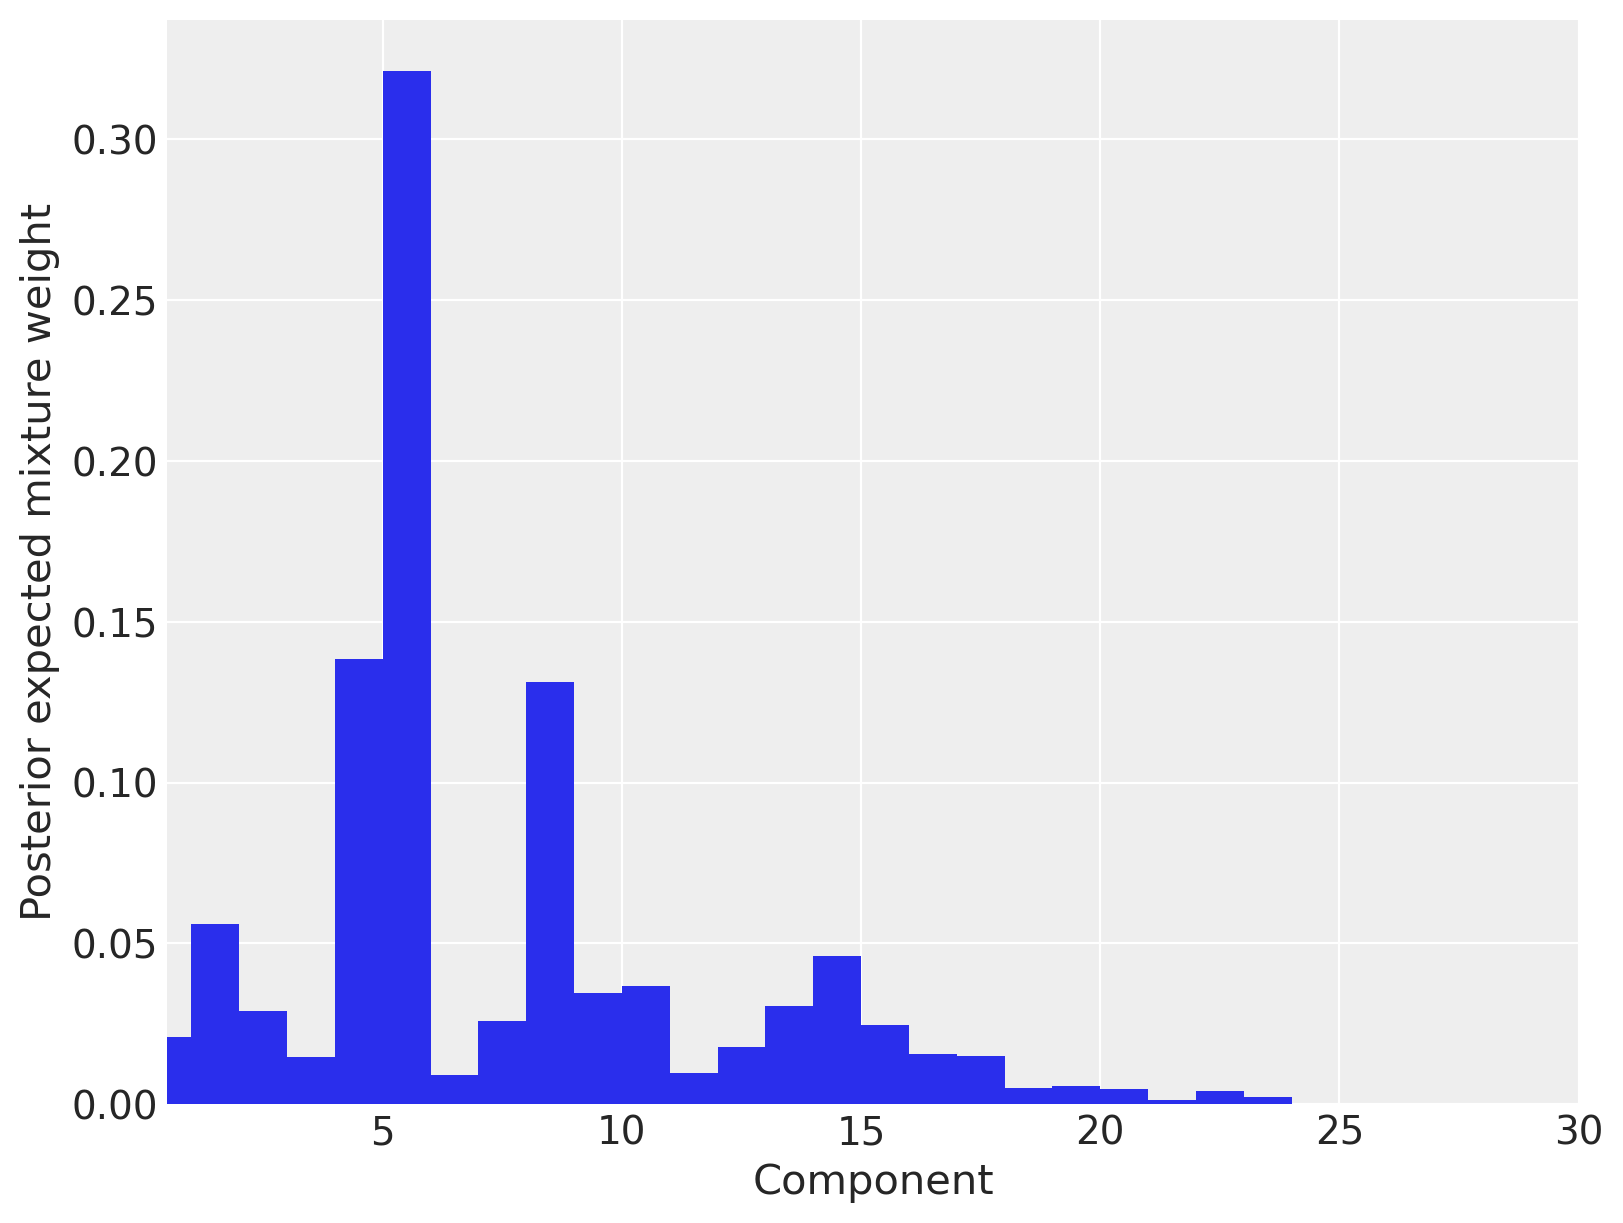

In [388]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(K) + 1

ax.bar(plot_w-0.5 , trace["w"].mean(axis=0), width=1.0, lw=0)

ax.set_xlim(0.5, K)
ax.set_xlabel("Component")

ax.set_ylabel("Posterior expected mixture weight");

print("weights shape =", trace["w"].shape)

In [389]:
x_plot = np.linspace(0, 20000, 4096)
post_pdf_contribs = sp.stats.gamma.pdf(
    x=np.atleast_3d(x_plot),
    a=trace["alpha_"][:, np.newaxis, :],
    scale=1/trace["beta_"][:, np.newaxis, :],
)
post_pdfs = (trace["w"][:, np.newaxis, :] * post_pdf_contribs).sum(axis=-1)

post_pdf_low, post_pdf_high = np.percentile(post_pdfs, [2.5, 97.5], axis=0)
post_pdf_contribs.shape

(50, 4096, 30)

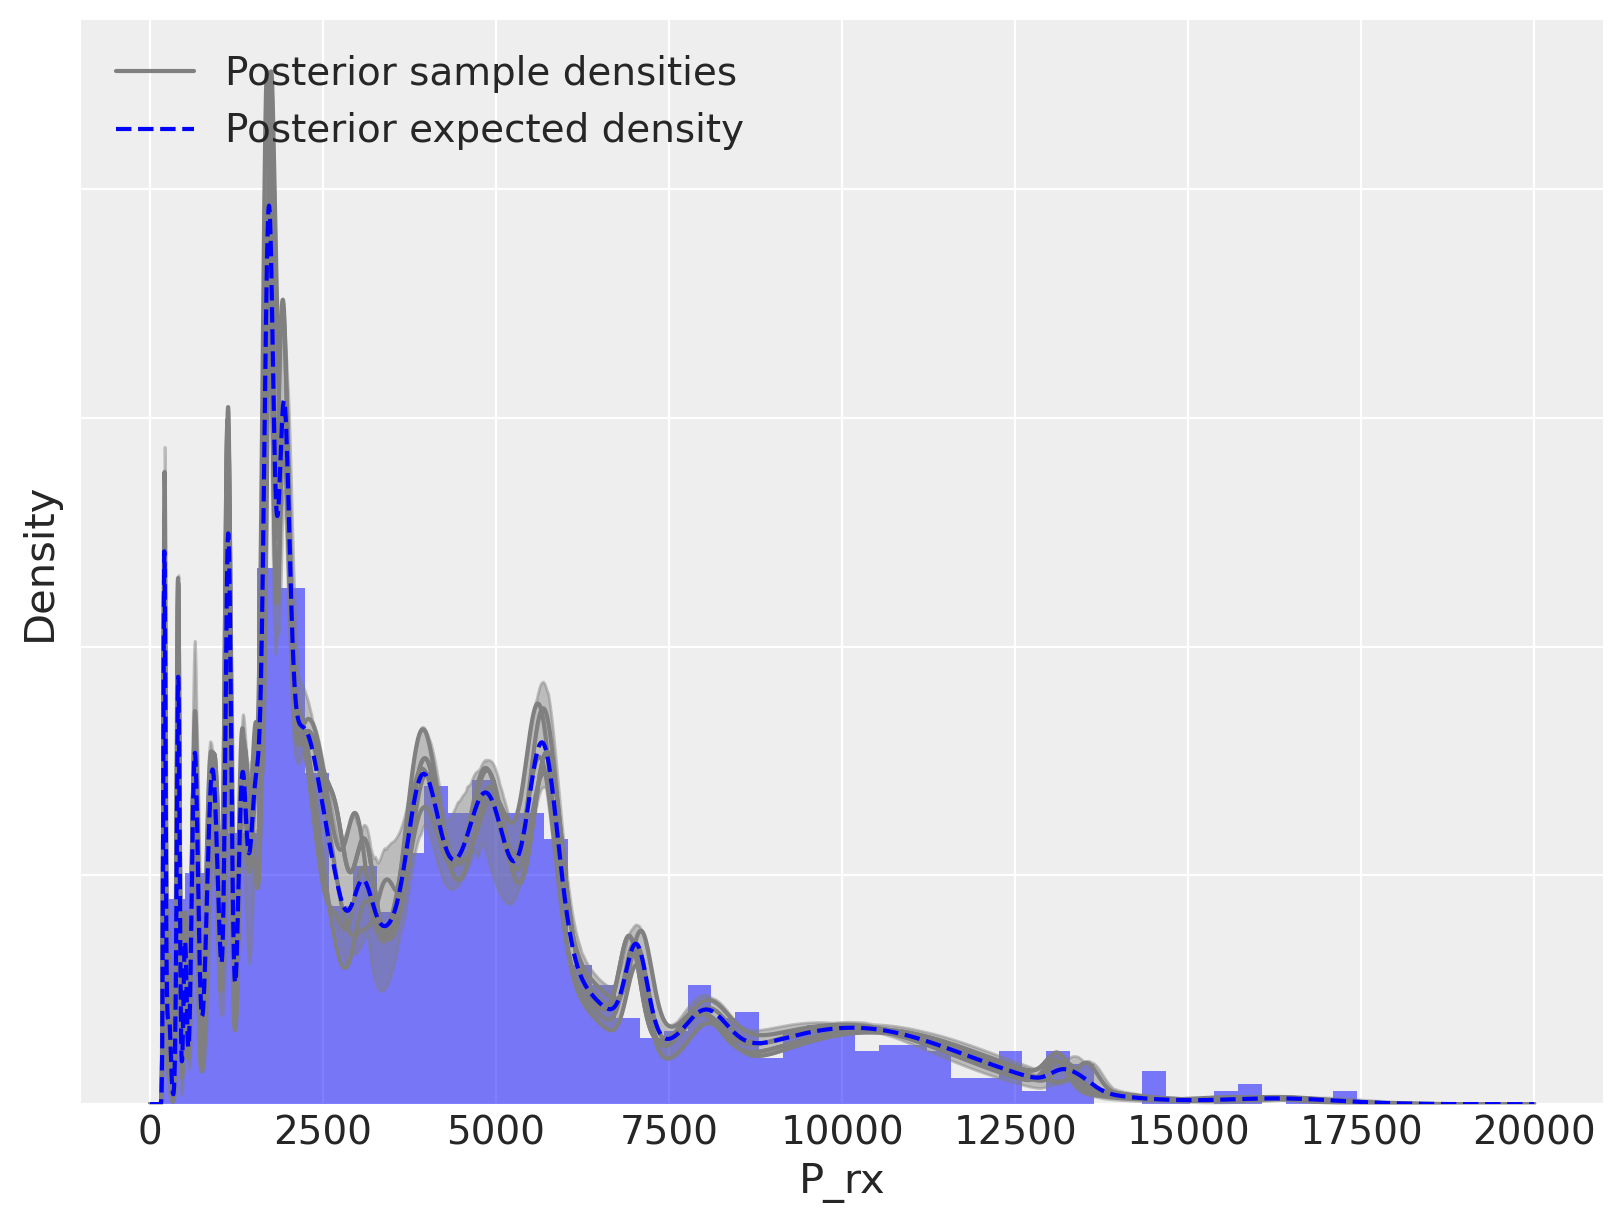

In [390]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 50
ax.hist(x, bins=n_bins, density=True, color="blue", lw=0, alpha=0.5)

ax.fill_between(x_plot, post_pdf_low, post_pdf_high, color="gray", alpha=0.45)
ax.plot(x_plot, post_pdfs[0],"-", c="gray", label="Posterior sample densities")
ax.plot(x_plot, post_pdfs[::10].T,"-", c="gray")
ax.plot(x_plot, post_pdfs.mean(axis=0), "--", c="blue", label="Posterior expected density")

ax.set_xlabel("P_rx")

ax.set_yticklabels([])
ax.set_ylabel("Density")

ax.legend(loc=2);

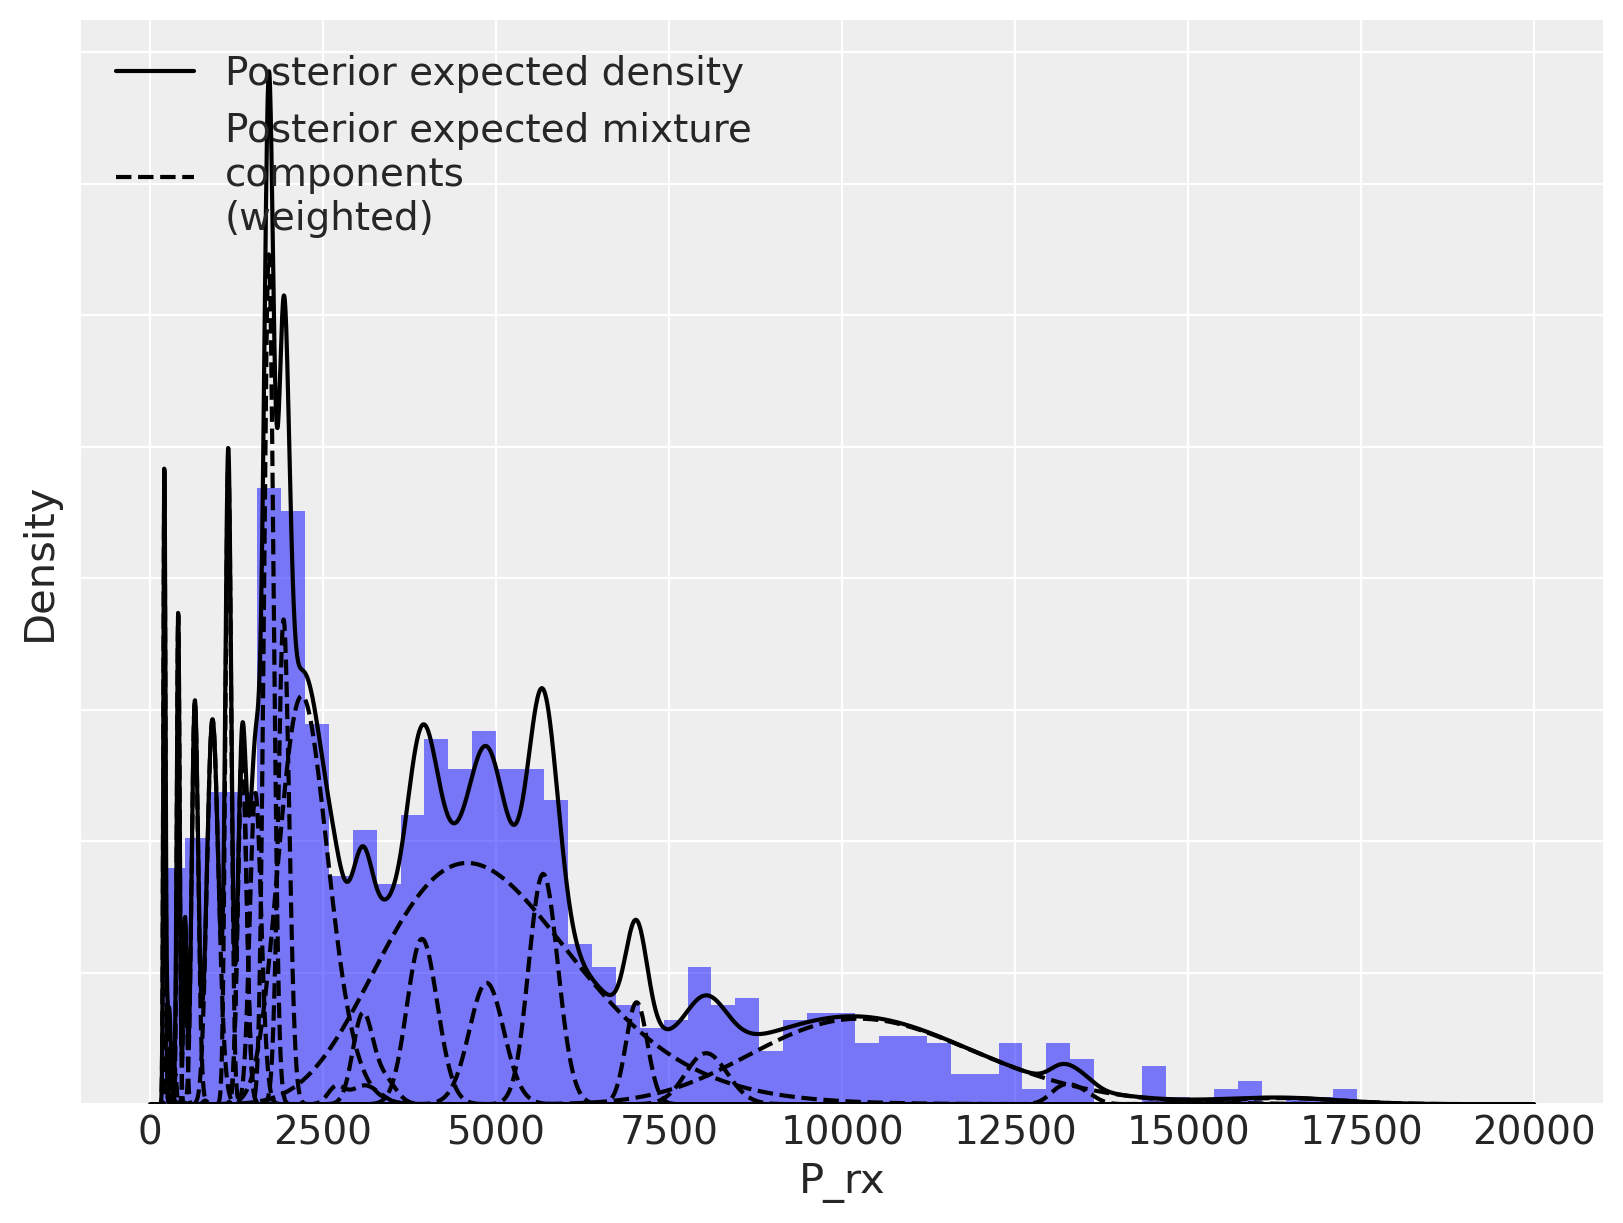

In [391]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 50
ax.hist(x, bins=n_bins, density=True, color="blue", lw=0, alpha=0.5)

ax.plot(x_plot, post_pdfs.mean(axis=0), c="k", label="Posterior expected density")
ax.plot(
    x_plot,
    (trace["w"][:, np.newaxis, :] * post_pdf_contribs).mean(axis=0)[:, 0],
    "--",
    c="k",
    label="Posterior expected mixture\ncomponents\n(weighted)",
)
ax.plot(x_plot, (trace["w"][:, np.newaxis, :] * post_pdf_contribs).mean(axis=0), "--", c="k")

ax.set_xlabel("P_rx")

ax.set_yticklabels([])
ax.set_ylabel("Density")

ax.legend(loc=2);

In [378]:
mat_file = {  
                "generated_mixture_data" : x, 
                "x_plot" : x_plot, 
                "w_trace" : trace["w"][:, np.newaxis, :], 
                "alpha_trace" : trace["alpha_"][:, np.newaxis, :], 
                "beta_trace" : trace["beta_"][:, np.newaxis, :], 
                "post_pdf_contribs": post_pdf_contribs, 
                "weighted_post_pdf_contribs": (trace["w"][:, np.newaxis, :] * post_pdf_contribs), 
                "weighted_post_pdf_contribs_means": (trace["w"][:, np.newaxis, :] * post_pdf_contribs).mean(axis=0),  
                "post_pdfs":  post_pdfs, 
                "post_pdfs_means":   post_pdfs.mean(axis=0)  }

savemat("mat_file_deneme_alpha_5.mat", mat_file)